In [1]:
import os
import string
import numpy as np
from PIL import Image
from pickle import dump
from pickle import load

In [2]:
# To get pre-trained model Xception
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



In [3]:
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/tmp/ipykernel_651401/3755642754.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

# 5 functions for cleaning and preparing text.

In [4]:
# Load the document file into memory
def load_fp(filename):
    #open file to read
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

In [5]:
#Get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split('\n')
    #print("captions", type(captions),captions[:5])
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        #print("single_caption",img,"and",caption)
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [6]:
#Data cleaning function will convert all uppwe case alphabates to lowercase, 
#removing punctuations and words contatining numbers

def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img,caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            descp = img_caption.split()
            
            #uppercase to lower case
            descp = [ wrd.lower() for wrd in descp]
            
            #remove punctuation from each token
            descp = [ wrd.translate(table) for wrd in descp]
            
            #remove hanging 's and a
            descp = [ wrd for wrd in descp if (len(wrd)>1)]
            
            #remove words containing numbers with them
            descp = [ wrd for wrd in descp if (wrd.isalpha())]
            
            #converting back to string
            img_caption = ' '.join(descp)
            
            captions[img][i] = img_caption
            
    return captions
            
            

In [7]:
#Create a vocabulary from all the unique words extracted from descriptions
def txt_vocab(descriptions):
    #to build a vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [8]:
#To save all descriptions in one file 
def save_descriptions(descriptions,filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' +desc)
        data = "\n".join(lines)
        file = open(filename, 'w')
        file.write(data)
        file.close()

In [9]:
#set these path according to project folder in your syster, 
dataset_text = "/home/ckpl/Documents/Experiments/IMG_CAPTION"


#To Prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
# print(filename)

descriptions = img_capt(filename)
print("length of descriptions = ", len(descriptions), list(descriptions.items())[:2],'\n')

#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
print(list(clean_descriptions.items())[0])

#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("lenght of vocabulary = ", len(vocabulary),[True if 'a' in vocabulary else 'ok'])

#Saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")

length of descriptions =  8092 [('1000268201_693b08cb0e.jpg', ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']), ('1001773457_577c3a7d70.jpg', ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'])] 

('1000268201_693b08cb0e.jpg', ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']

# Extracting features from images

In [10]:
#Function to extract features for all images and save into pickle
def extract_features(dirc):
    model = Xception(include_top = False, pooling = 'avg')
    features = {}
    for pic in tqdm(os.listdir(dirc)):
        file = dirc + "/" + pic
        img = file.split('/')[-1]
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis =0)
        #image = preprocess_imput(image)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        features[img] = feature
    return features

In [11]:
dataset_images = "/home/ckpl/Documents/Experiments/IMG_CAPTION"
dataset_images = dataset_images + "/" + "Flicker8k_Dataset"

# features = extract_features(dataset_images)
# dump(features, open("features.p","wb"))

#To directly load the features from pickle file
features = load(open("features.p","rb"))

# Loading dataset for model training

In [12]:
#Load the dataset - Images
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    return photos

In [13]:
#Load clean descriptions
def load_clean_descriptions(filename, photos):
    file = load_fp(filename)
    descriptions = {}
    for line in file.split("\n"):
#         print("line",line)
        words = line.split()
#         print("words",words)
        if len(words)<1:
            continue
        image, image_caption = words[0], words[1:]
#         print(image, image_caption)
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [14]:
#loading all features
def load_features(photos):
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [15]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
# print("train_imgs",train_imgs)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
# print("train_descriptions",train_descriptions)
train_features = load_features(train_imgs)

# Tokenizing The Vocabulary

In [16]:
#convert dictionary to clear list of descriptions
def dict_2_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [17]:
#creating tokenizer class - this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_2_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

#give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [18]:
def max_length(descriptions):
    desc_list = dict_2_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

# Create a Data generator

In [19]:
from tensorflow.keras.utils import to_categorical
#from keras.utils import to_categorical

#data generator, used by model.fit_generator():
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #print("key",key,description_list)
            #retrive photo features
            feature = features[key][0]
            inp_image,inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield[[inp_image, inp_seq], op_word]
            
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    
    #move through each description for the image 
    for desc in desc_list:
        #encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
#         print("seq",seq)
        #divide one sequence into various x,y pairs
        for i in range (1, len(seq)):
            # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            #pad input sequence
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            #store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)         

In [20]:
#To check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))

a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

# Define The CNN-RNN model

In [21]:

from keras.models import Model, load_model
from keras.layers.merge import add
from keras.layers import Input, Dense
from keras.layers import LSTM, Embedding, Dropout

from keras.utils.vis_utils import plot_model

#define the captioning model
def define_model(vocab_size, max_lenght):
    
    #features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    #LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    #merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    #merge it [image, seq][word]
    model = Model(inputs = [inputs1, inputs2], outputs= outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    #sumarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes= True)
    return model

# Training The ImageCaptionGenerator model

In [23]:
#train our model
print('dataset:', len(train_imgs))
print('Descriptions: train=',len(train_descriptions))
print('photos: train=', len(train_features))
print('vocabulary size:', vocab_size)
print('Description Length:', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)

#creating a directory named models to save our models
# os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch = steps, verbose=1)
    model.save("models/model_"+ str(i)+".h5")

dataset: 6000
Descriptions: train= 6000
photos: train= 6000
vocabulary size: 7577
Description Length: 32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 256)      1939712     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_3[0][0]']    

/tmp/ipykernel_651401/3532243413.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch = steps, verbose=1)


   1/6000 [..............................] - ETA: 3:36:52 - loss: 8.9364

2024-02-06 18:09:27.977047: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6000/6000 [==============================] - 161s 27ms/step - loss: 2.7689


# Testing the ImageCaptionGenerator model

In [27]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())

# img_path = args['image']
img_path = "/home/ckpl/Documents/Experiments/IMG_CAPTION/twomen.jpg"

In [28]:
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    
    # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
           image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        print("pred",pred,word)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


pred 12 two
pred 62 children
pred 16 are
pred 33 playing
pred 3 in
pred 4 the
pred 40 grass
pred 1 end



des start two children are playing in the grass end


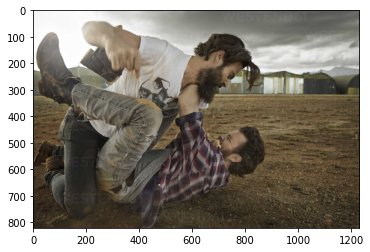

In [29]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print("des",description)
plt.imshow(img)